# Plotting PHM Data using PCA Reduction

Currently, our data is difficult to read directly from a sensor. Although we have some success with Feedforward Neural Networks (FNNs) used with all 24 sensor points our score still isn't reasonable for us to. Because of this, we should look to modify our data.

## Regime Partitioning

In most examples using trajectory, regime partitioning is used to better understand the data. This can be seen in both the 1st place winner's results and in several, newer papers.

In our case, we will be using PCA Reduction to attempt to partition different regions. This seems viable due to previous cases with Heimes comparing 2 points resulting in 6 clusters, each based on an operating condition.

In [1]:
import data_tools as dt
import data_dir as dd

import matplotlib.pyplot as plt

In [2]:
direct_phm_data = dt.import_nasa_dataset(dd.PHM_TRAIN)
phm_data = dt.get_nasa_data(dd.PHM_TRAIN)
phm_units = dt.get_nasa_units(dd.PHM_TRAIN)

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

direct_pca = pca.fit_transform(direct_phm_data[:, 2:])

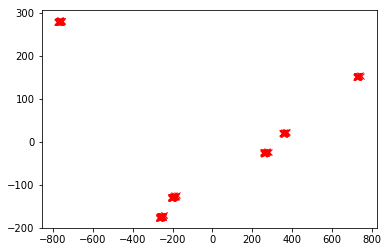

In [4]:
plt.plot(direct_pca[:223, 0], direct_pca[:223, 1], 'rx')
plt.show()

As we can see, we retrieve 6 clusters that are believed to be based on the operating condition. If we repeat this set with direct data from our CMAPSS datasets, we will find similar results except with CMAPSS_1 and CMAPPS_3 which only use 1 operating condition.

In [5]:
modified_pca = pca.fit_transform(phm_data[:, 2:])

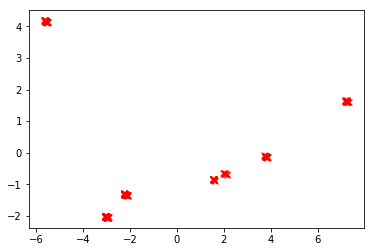

In [6]:
plt.plot(modified_pca[:223, 0], modified_pca[:223, 1], 'rx')
plt.show()

Small modifications (scaling) seems to cause splits and different distances between the clusters, creating a 7th cluster. This might be due to the small difference in operating sensors, resulting in larger gaps.

## Merging Clusters of Regimes

Although it is feasible to train on 1 cluster, it is still incredibly difficult. Splitting of data means larger chances of overfitting and miscalculating probabilities. Because of this, we must attempt to merge our clusters together to have a better chance of understanding.

Using KMeans, we can identify each our clusters in our direct pca.

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6)

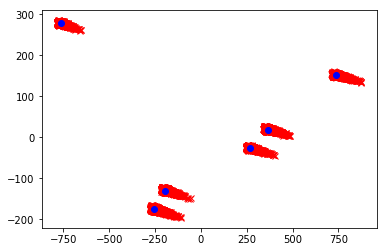

In [8]:
kmeans.fit(direct_pca)
plt.plot(direct_pca[:, 0], direct_pca[:, 1], 'rx')
plt.plot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 'bo')
plt.show()

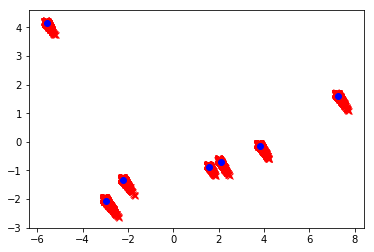

In [9]:
kmeans_modified = KMeans(n_clusters=7)
kmeans_modified.fit(modified_pca)
plt.plot(modified_pca[:, 0], modified_pca[:, 1], 'rx')
plt.plot(kmeans_modified.cluster_centers_[:, 0], kmeans_modified.cluster_centers_[:, 1], 'bo')
plt.show()

Using our clusters, we can predict each point and subtract the given center for that cluster. This will result in a more centered data.

Also, as seen in our previous graph, we expect each cluster to have similar behaviors and trends.

In [10]:
import numpy as np
import warnings

combined_pca = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for point in direct_pca:
        cluster = kmeans.predict(point)
        combined_pca.append(point.tolist())
        combined_pca[len(combined_pca) - 1][0] -= kmeans.cluster_centers_[cluster][0][0]
        combined_pca[len(combined_pca) - 1][1] -= kmeans.cluster_centers_[cluster][0][1]
    combined_pca = np.array(combined_pca)

In [11]:
combined_modified_pca = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for point in modified_pca:
        cluster = kmeans_modified.predict(point)
        combined_modified_pca.append(point.tolist())
        combined_modified_pca[len(combined_modified_pca) - 1][0] -= kmeans_modified.cluster_centers_[cluster][0][0]
        combined_modified_pca[len(combined_modified_pca) - 1][1] -= kmeans_modified.cluster_centers_[cluster][0][1]
    combined_modified_pca = np.array(combined_modified_pca)

Our results can be seen below. Points that are more blue are earlier in a series and points that are more yellow are closer to the end of a series.

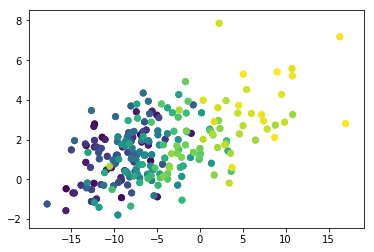

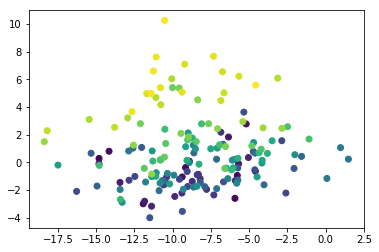

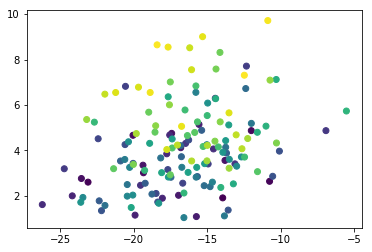

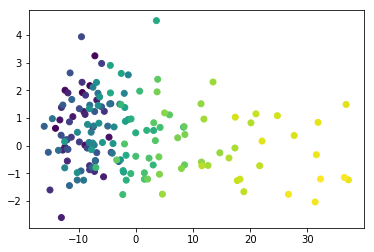

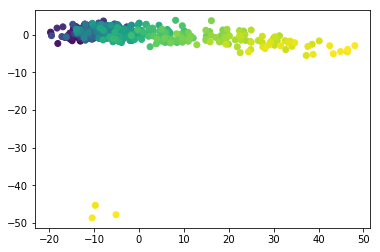

In [22]:
total = 0
for unit in phm_units[:5]:
    color = [str(i/(unit.shape[0] * 1.)) for i in xrange(unit.shape[0])]
    plt.scatter(combined_pca[total:total+unit.shape[0], 0], combined_pca[total:total+unit.shape[0], 1], c=color)

    plt.show()
    total += unit.shape[0]

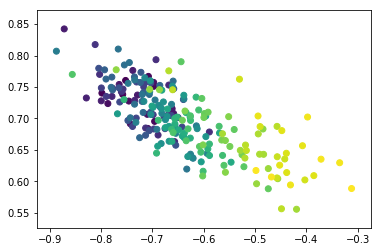

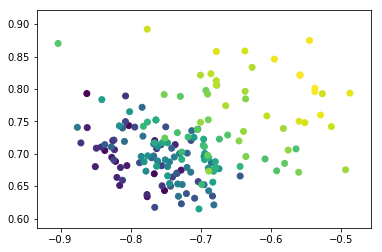

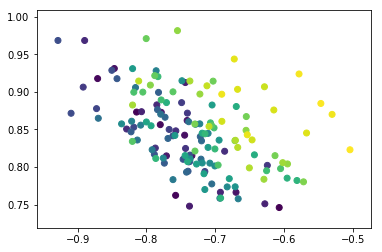

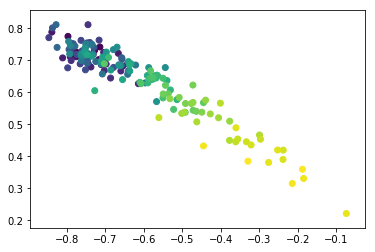

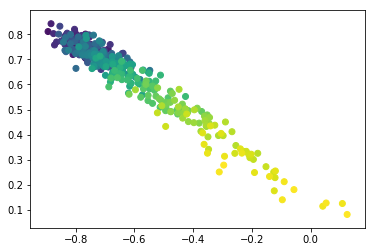

In [20]:
total = 0
from sklearn import preprocessing

combined_modified_pca = preprocessing.minmax_scale(combined_modified_pca, feature_range=(-1, 1))
for unit in phm_units[:5]:
    color = [str(i/(unit.shape[0] * 1.)) for i in xrange(unit.shape[0])]
    plt.scatter(combined_modified_pca[total:total+unit.shape[0], 0], 
                combined_modified_pca[total:total+unit.shape[0], 1], c=color)
    plt.show()
    total += unit.shape[0]

As we can see, there are obvious trends for each of these with minimum noise.

## Improving

How can we use this with more of our sensor data?

Because we have 3 operating conditions, we can instead try to compare using those 3 instead of using a PCA to reduce our dimensionality.

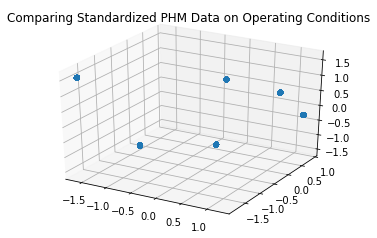

In [14]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(phm_data[:, 2], phm_data[:, 3], phm_data[:, 4])
ax.set_title('Comparing Standardized PHM Data on Operating Conditions')

plt.show()

In [20]:
full_kmeans = KMeans(n_clusters=6).fit(phm_data[:, 2:])

In [30]:
test_data = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for point in phm_data:
        cluster = full_kmeans.predict(point[2:])
        test_data.append(point[2:].ravel() - full_kmeans.cluster_centers_[cluster].ravel())
test_data = np.array(test_data)

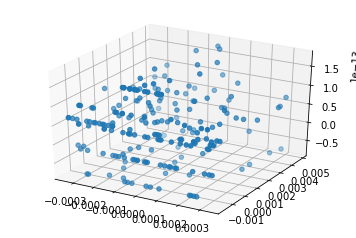

In [33]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(test_data[:223, 0], test_data[:223, 1], test_data[:223, 2])
plt.show()